In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/titanic/train.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/gender_submission.csv


# Exploratory Data Analysis

In [2]:
# lets see what the data looks like
training_data = pd.read_csv("/kaggle/input/titanic/train.csv")
training_data

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S
...,...,...,...,...,...,...,...,...,...,...,...,...
886,887,0,2,"Montvila, Rev. Juozas",male,27.0,0,0,211536,13.0000,NaN,S
887,888,1,1,"Graham, Miss. Margaret Edith",female,19.0,0,0,112053,30.0000,B42,S
888,889,0,3,"Johnston, Miss. Catherine Helen ""Carrie""",female,NaN,1,2,W./C. 6607,23.4500,NaN,S
889,890,1,1,"Behr, Mr. Karl Howell",male,26.0,0,0,111369,30.0000,C148,C


In [3]:
# get dataset description
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   PassengerId  891 non-null    int64  
 1   Survived     891 non-null    int64  
 2   Pclass       891 non-null    int64  
 3   Name         891 non-null    object 
 4   Sex          891 non-null    object 
 5   Age          714 non-null    float64
 6   SibSp        891 non-null    int64  
 7   Parch        891 non-null    int64  
 8   Ticket       891 non-null    object 
 9   Fare         891 non-null    float64
 10  Cabin        204 non-null    object 
 11  Embarked     889 non-null    object 
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


## Column Descriptions

| Column Name  | Description |
|--------------|-------------|
| PassengerId  | ID         |
| Survived     | Survived (0,1)         |
| Pclass       | Ticket class (0,1,3)         |
| Name         | Name         |
| Sex          | Gender (male, female)         |
| Age          | Age         |
| SibSp        | # siblings/spouses on titanic         |
| Parch        | # parents/chu         |
| Ticket       | Ticket number         |
| Fare         | Fare         |
| Cabin        | Cabin number         |
| Embarked     | Point of embarkation (S, C, Q)         |


## Handle Missing Values

In [4]:
# see number of missing values per column
training_data.isnull().sum()

PassengerId      0
Survived         0
Pclass           0
Name             0
Sex              0
Age            177
SibSp            0
Parch            0
Ticket           0
Fare             0
Cabin          687
Embarked         2
dtype: int64

In [5]:
# for simplicity, drop cabin column (high proportion of rows are missing)
training_data = training_data.drop("Cabin", axis=1)

# we can impute missing age with mean age
# this definitely has room for improvement (get age from SibSp/Parch?)
mean_age = training_data["Age"].mean()
training_data["Age"] = training_data["Age"].fillna(mean_age)

# we can impute missing embarked with most common embarked
# again, there is room for improvement (get embarked from Cabin/Fare?)
popular_embarked = training_data["Embarked"].value_counts().index[0]
training_data["Embarked"] = training_data["Embarked"].fillna(popular_embarked)

# see new shape of data
training_data.shape

(891, 11)

In [6]:
# deal with non-categorical string columns (Cabin, Name, Ticket)

# unfortunately, I do not know how to deal with these columns
# maybe a Kaggle/other model can be trained to classify based on these columns then used in an ensemble model?

# for now, simply drop these columns (Cabin already dropped)
training_data = training_data.drop(["Name", "Ticket"], axis=1)

training_data.shape

(891, 9)

In [7]:
# now we can load and preprocess datasets as follows

# load datasets
training_data = pd.read_csv("/kaggle/input/titanic/train.csv")
training_data = training_data.drop(["PassengerId", "Cabin", "Name", "Ticket"], axis=1)

testing_data = pd.read_csv("/kaggle/input/titanic/test.csv")
testing_data = testing_data.drop(["Cabin", "Name", "Ticket"], axis=1)

print(f"Training dataset size: {training_data.shape}")
print(f"Testing dataset size: {testing_data.shape}")

Training dataset size: (891, 8)
Testing dataset size: (418, 8)


## Determine Imputation Methods

We can look at the distribution of features to determine the best methods of imputing values

array([[<Axes: title={'center': 'Survived'}>,
        <Axes: title={'center': 'Pclass'}>],
       [<Axes: title={'center': 'Age'}>,
        <Axes: title={'center': 'SibSp'}>],
       [<Axes: title={'center': 'Parch'}>,
        <Axes: title={'center': 'Fare'}>]], dtype=object)

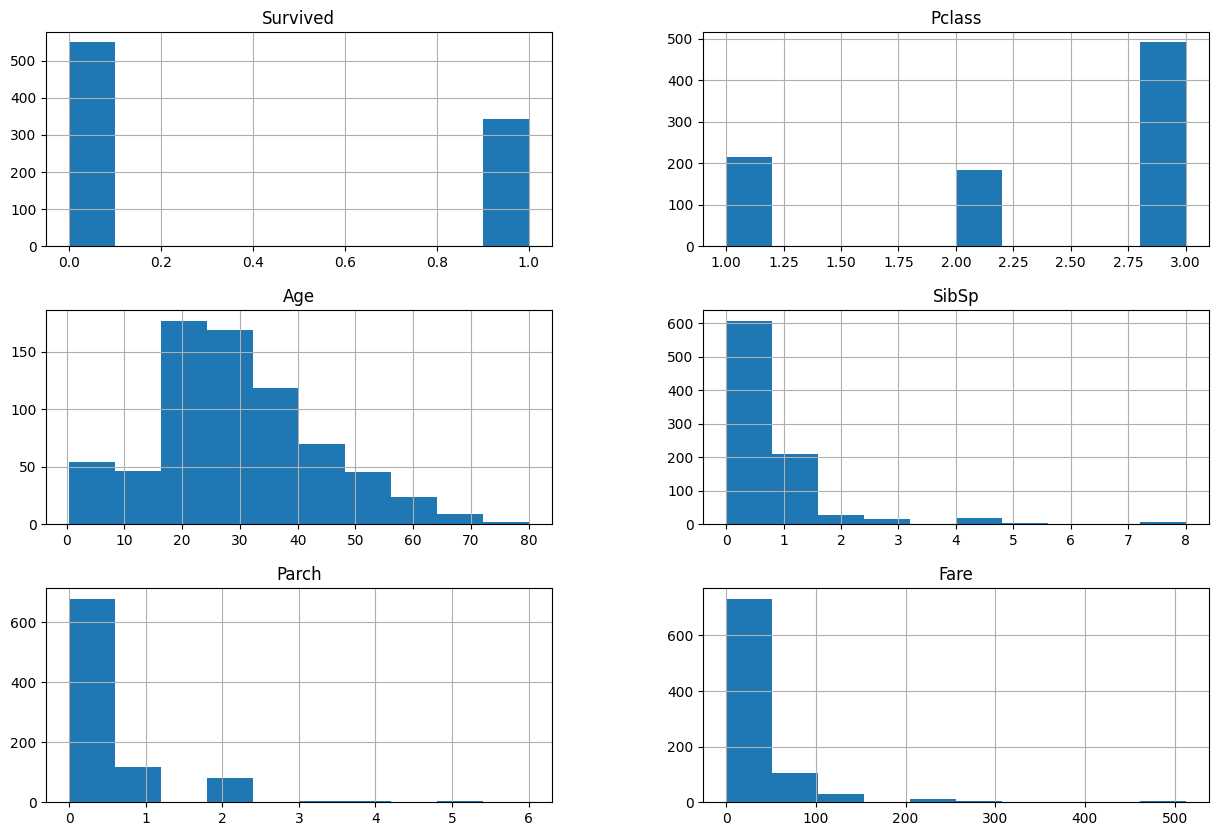

In [8]:
# see histogram of numerical features
# categorical features that only have integers will be shown here too
training_data.hist(figsize=(15, 10))

It looks like there are some outliers in numerical features (ex, age).
Thus, we will use median to impute values for numerical features.

We will use most frequent value to impute for categorical features.

In [9]:
training_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 8 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   Survived  891 non-null    int64  
 1   Pclass    891 non-null    int64  
 2   Sex       891 non-null    object 
 3   Age       714 non-null    float64
 4   SibSp     891 non-null    int64  
 5   Parch     891 non-null    int64  
 6   Fare      891 non-null    float64
 7   Embarked  889 non-null    object 
dtypes: float64(2), int64(4), object(2)
memory usage: 55.8+ KB


Model Pipeline

1. Impute missing values (numerical->median, categorical->most frequent)
2. Process columns with numerical/categorical processor
3. Choose model
4. Fit model

With this sklearn model pipeline we can easily train, test, and use various kinds of models

In [10]:
# specify feature types

numerical_features = ["Age", "SibSp", "Parch", "Fare"]
categorical_features = ["Pclass", "Sex", "Embarked"]

In [11]:
from sklearn.impute import SimpleImputer
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import make_pipeline, Pipeline

# lets make a function that gives us an sklearn model pipeline
# given: feature columns of each type, sklearn model for classification

def sklearn_model_pipeline(numerical_features: list, categorical_features: list, sklearn_model: object) -> Pipeline:
    # define preprocessors
    categorical_preprocessor = OneHotEncoder(handle_unknown="ignore")
    numerical_preprocessor = StandardScaler()

    # define transformers with imputation and preprocessing methods
    numerical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="median")),
            ("scaler", StandardScaler()),
        ]
    )
    categorical_transformer = Pipeline(
        steps=[
            ("imputer", SimpleImputer(strategy="most_frequent")),
            ("onehot", OneHotEncoder(handle_unknown="ignore"))
        ]
    )
    
    # define preprocessor for all data
    preprocessor = ColumnTransformer(
        transformers=[
            ("numerical_transformer", numerical_transformer, numerical_features),
            ("categorical_transformer", categorical_transformer, categorical_features),
        ]
    )

    # create model pipeline
    model_pipeline = Pipeline(
        steps=[
            ("preprocessor", preprocessor),
            ("classifier", sklearn_model),
        ]
    )
    return model_pipeline

In [12]:
from sklearn.linear_model import LogisticRegression

# lets create an example pipeline and see what it looks like
lr_pipeline = sklearn_model_pipeline(numerical_features, categorical_features, LogisticRegression())

lr_pipeline

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', LogisticRegression())])

In [13]:
from sklearn.model_selection import cross_validate

from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, HistGradientBoostingClassifier
from sklearn.svm import SVC

# create data and target subsets of training data
data_train, target_train = (
    training_data.drop(columns="Survived"),
    training_data["Survived"],
)

# list of models we want to test classification accuracy for
models_list = [
    LogisticRegression(),
    RandomForestClassifier(),
    GradientBoostingClassifier(),
    HistGradientBoostingClassifier(),
    SVC()
]

for model in models_list:
    model_pipeline = sklearn_model_pipeline(numerical_features, categorical_features, model)
    cv_results = cross_validate(model_pipeline, data_train, target_train, cv=10) # for the size of our datset, 10 folds seems reasonable
    scores = cv_results["test_score"]
    print(f"Model: {model}, Accuracy: {scores.mean()}")

Model: LogisticRegression(), Accuracy: 0.7991260923845193
Model: RandomForestClassifier(), Accuracy: 0.8070287141073658
Model: GradientBoostingClassifier(), Accuracy: 0.8238202247191012
Model: HistGradientBoostingClassifier(), Accuracy: 0.8148813982521848
Model: SVC(), Accuracy: 0.823820224719101


It looks like the last 3 classification models have similar performance. This is validated by repeating the tests a couple of times. We can use the GradientBoostingClassifier for making predictions on the test dataset. First, we can fit the selected model on all of the training data.

In [14]:
best_model = GradientBoostingClassifier()
best_model_pipeline = sklearn_model_pipeline(numerical_features, categorical_features, best_model)
best_model_pipeline.fit(data_train, target_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('numerical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='median')),
                                                                  ('scaler',
                                                                   StandardScaler())]),
                                                  ['Age', 'SibSp', 'Parch',
                                                   'Fare']),
                                                 ('categorical_transformer',
                                                  Pipeline(steps=[('imputer',
                                                                   SimpleImputer(strategy='most_frequent')),
                                                                  ('onehot',
                                                                   OneHotEncoder(handle_unknown='ignore'))]),
                                                  ['Pclass', 'Sex',
                                                   'Embarked'])])),
                ('classifier', GradientBoostingClassifier())])

# Get Test Set Predictions!

In [15]:
data_test, passenger_id_test = (
    testing_data.drop(columns="PassengerId"),
    testing_data["PassengerId"],
)

test_pred = best_model_pipeline.predict(data_test)

submission_df = pd.DataFrame({
    'PassengerId': passenger_id_test,
    'Survived': test_pred
})

submission_df.to_csv("submission.csv", index=False)

submission_df

,PassengerId,Survived
0,892,0
1,893,0
2,894,0
3,895,0
4,896,0
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
